# Large Language Models are not reasoning engines

The rise or Generative AI post-ChatGPT has had a huge impact on the collective imagination. Many people speak about intelligence, in some extreme cases people have mentioned that some LLMs are sentient! The LLMs providers (like OpenAI or Anthropic) have not helped fighting against these thoughts, since they also talk about their models in almost a human way, Anthropic calling its Language Model Claude (thanks for making my name popular :-)), and OpenAI giving a personal touch to the LLM via a human voice.

But can Large Language Models think? And if not, what are they good at?

In this post I will guide you through two examples that clearly show the limits of LLMs in terms of reasoning. There is very some programming in this article, but you can skip it and just read the results. I have decided to provide the programming code to let readers be able to reproduce the examples easily. I will also explain why these examples do not work, which will give us hints on when we can trust the "reasoning abilities" of Language Models, and when we cannot.

In the end I will also mention where we believe the LLMs can be best used, in data extraction and in writing, and why I think this is the case.

But first, let's introduce two examples where we can clearly observe the limitations of the reasoning capabilities of LLMs.

## Caesar Cipher

This example was provided by Subbarao Kambhampati, a renowned AI Researcher.

An interesting method to encrypt a message is the Caesar Cipher. This consists or replacing each letter with another letter of the alphabet, by shifting everything by a given number of letters.

For example, using n=3, the letter "a" is replaced by the letter "d", which is three letters further than "a" in the alphabet.

This is pretty easy and we can trust that anyone who has some reasoning abilities would be able to decrypt such a text. Let's test a Language Model on this exercise.

In order to do this we introduce a function to encrypt a text, and we introduce a function where ChatGPT decrypts it.

In [96]:
def cipher(text, shift, mode='encrypt'):
    result = ""
    for char in text:
        if char.isalpha():
            # Determine the ASCII offset based on whether the character is uppercase or lowercase
            ascii_offset = 65 if char.isupper() else 97
            
            # Apply the shift (for encryption) or reverse shift (for decryption)
            if mode == 'encrypt':
                shifted = (ord(char) - ascii_offset + shift) % 26
            else:  # decrypt
                shifted = (ord(char) - ascii_offset - shift) % 26
            
            # Convert back to a character and add to the result
            result += chr(shifted + ascii_offset)
        else:
            # If the character is not a letter, leave it unchanged
            result += char
    return result

Let's test it on a simple example:

In [97]:
text = "The sun rises in the east and sets in the west."
print(f"Text: {text}")
encrypted_text = cipher(text=text, shift=3, mode='encrypt')
print(f"Encrypted text: {encrypted_text}")
decrypted_text = cipher(text=encrypted_text, shift=3, mode='decrypt')
print(f"Decrypted text: {decrypted_text}")

Text: The sun rises in the east and sets in the west.
Encrypted text: Wkh vxq ulvhv lq wkh hdvw dqg vhwv lq wkh zhvw.
Decrypted text: The sun rises in the east and sets in the west.


Let's make the following experiment: we will shift the text by 0, 1, 2, ..., 25 and ask a Language Model to decrypt it. Let's see what happens.

In [98]:
text = "The sun rises in the east and sets in the west."

In [99]:
encrypted_text_list = []
for n in range(26):
    encrypted_text = cipher(text, shift=n, mode='encrypt')
    encrypted_text_list.append(encrypted_text)
print(f"Encrypted text with a shift of 5: {encrypted_text_list[5]}")

Encrypted text with a shift of 5: Ymj xzs wnxjx ns ymj jfxy fsi xjyx ns ymj bjxy.


In [107]:
from openai import OpenAI
client = OpenAI()
# OPENAI_API_KEY=YOUR_API_KEY

def decipher(encrypted_text):
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      temperature = 0.0,
      messages=[
        {"role": "system", "content": "You are an AI assistant that is asked to decipher a text. The input is an encrypted text. Provide only the output text, no explanations at all and no introduction."},
        {"role": "user", "content": f"Encrypted text: {encrypted_text}\n\n Decrypted text: "}
      ]
    )
    return completion.choices[0].message.content

In [101]:
decrypted_text_list = []
for n in range(26):
    decrypted_text= decipher(encrypted_text_list[n])
    decrypted_text_list.append(decrypted_text)
print(f"Decrypted text with a shift of 5: {decrypted_text_list[5]}")

Decrypted text with a shift of 5: The way to think is the thought and the source of the thought.


In [102]:
check = []
for n in range(26):
    if text in decrypted_text_list[n]:
        check.append(True)
    else:
        check.append(False)       

In [104]:
green = '\033[92m'
red = '\033[91m'
print("n  | Decrypted text")
for n in range(26):
    if check[n]:
        color=green
    else:
        color=red
    print(f"{color}{n:02d} | {decrypted_text_list[n]}")

n  | Decrypted text
00 | The sun rises in the east and sets in the west.
01 | The sun rises in the east and sets in the west.
02 | The son born to the man and wife of the town.
03 | The set dates in the case and sets in the week.
04 | The sun shines on the grass and flowers of the park.
05 | The way to think is the thought and the source of the thought.
06 | The key used for the code is the text not the word.
07 | The key words to the code are love and hate in the code.
08 | The sun shines on the white snow in the winter.
09 | The sky above us is the color of ever-changing love.
10 | Not all those who wander are lost.
11 | But not all wounds are visible to the human eye.
12 | The key to life is the love you live and the courage you give.
13 | The sun rises in the east and sets in the west.
14 | Not all who wander are lost.
15 | The end result of the decryption is the key to the code.
16 | The end goal of the data was the user end of the line.
17 | The end result of the decryption is th

The result is fascinating and very enlightning: it works only in very special cases: if the shift is very small (0, 1) or if the shift is 13, exactly in the middle.

How can we interpret this? The interpretation is that the Language Models do not reason. They imitate what they see in the training data they have been trained on. In this case, we can assume that there are many cipher examples on the web (the training data) where the letters are shifted by one or by 13, which seem to emerge as standard cases.

This example shows us that (i) the Language Models are good at repeating what they see in the training data, and (ii) the Language Models do not reason like humans do: they just mimic what they have seen at training time.

What does this teach us about the use of Language Models? It teaches us that we have to be extremely careful and need to ask ourselves the following: is my use case a repetiion of what we can find on the web, or is it totally new? If it is totally new, you cannot use it as such but you would have to either fine-tune your model by providing many similar examples or apply a different algorithm that is not typically based on Language Models.

That's a very interesting illustration of the limitations of Language Models. But you might argue: ok, this is a very specific example which requires the analysis of single letters, while Language Models are defined at word level (or more precisely at token level, which are words or parts of words), not at letter level.

Let's look at another example, which was given by François Chollet, a famous AI Researcher.

## The Monty Hall Problem

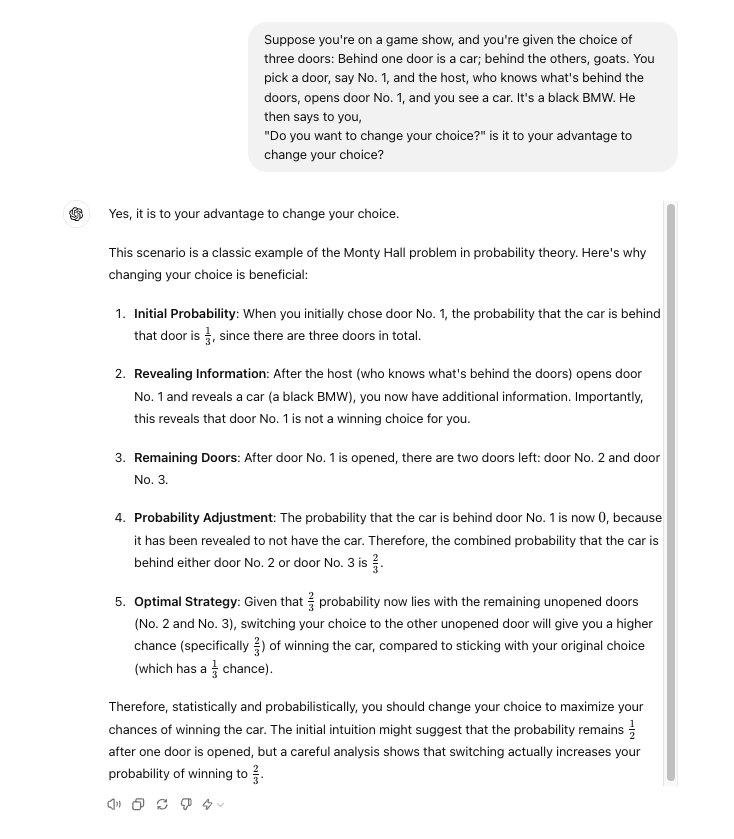

This example was generated in July 2024 with ChatGPT 3.5. It is obviously totally wrong. If you blindly follow this advice you might simply lose a car that you have virtually already won! The reason for this wrong answer is that this problem, called "The Monty Hall Problem", is a famous one and is typically formulated slightly differently. The answer to this famous problem is "yes", switching is the best strategy.

The Language Model, which has been trained on the web (that contains many times this "slightly different" example), provides the standard answer: "yes", switching is the best strategy.

## Conclusion

In conclusion, I want to highlight the fact that I am not at all saying the Language Models are useless. Language Models are extremely useful for many tasks, and they excel especially at tasks they have been trained on, like information extraction, summarization, writing, and to a certain extent, reasoning (but only on "standard problems").

But it is extremely important to be aware of the (serious) limitations of Language Models, and that you cannot trust blindly their reasoning abilities.

You can only trust their "reasoning abilities" for use cases which are repeated many times on the web, which is the natural training data the Language Models are trained on. You cannot assume that Language Models reason on any type of problem.